# Wasserstein GAN with Gradient Penalty (WGAN-GP)

### Goals
In this notebook, you're going to build a Wasserstein GAN with Gradient Penalty (WGAN-GP) that solves some of the stability issues with the GANs that you have been using up until this point. Specifically, you'll use a special kind of loss function known as the W-loss, where W stands for Wasserstein, and gradient penalties to prevent mode collapse.

*Fun Fact: Wasserstein is named after a mathematician at Penn State, Leonid Vaseršteĭn. You'll see it abbreviated to W (e.g. WGAN, W-loss, W-distance).*

### Learning Objectives
1.   Get hands-on experience building a more stable GAN: Wasserstein GAN with Gradient Penalty (WGAN-GP).
2.   Train the more advanced WGAN-GP model.



## Generator and Critic

You will begin by importing some useful packages, defining visualization functions, building the generator, and building the critic. Since the changes for WGAN-GP are done to the loss function during training, you can simply reuse your previous GAN code for the generator and critic class. Remember that in WGAN-GP, you no longer use a discriminator that classifies fake and real as 0 and 1 but rather a critic that scores images with real numbers.

#### Packages and Visualizations

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sys
import os
import logging
import datetime
from torchvision import transforms, datasets
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0")
torch.manual_seed(0) # Set for our testing purposes, please do not change!

# Save log
so = open("data_wgan.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so
get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)
torch.manual_seed(0) # Set for testing purposes, please do not change!
IMG_SIZE = 32
def show_tensor_images(image_tensor, num_images=25, size=(1, IMG_SIZE, IMG_SIZE)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

#### Generator and Noise

In [2]:
# class Generator(nn.Module):
#     '''
#     Generator Class
#     Values:
#         z_dim: the dimension of the noise vector, a scalar
#         im_chan: the number of channels of the output image, a scalar
#               (MNIST is black-and-white, so 1 channel is your default)
#         hidden_dim: the inner dimension, a scalar
#     '''
#     def __init__(self, z_dim=100, im_chan=1, hidden_dim=64):
#         super(Generator, self).__init__()
#         self.z_dim = z_dim
#         # self.input_dim = input_dim
#         # Build the neural network
#         # self.gen = nn.Sequential(
#         #     self.make_gen_block(z_dim, hidden_dim * 4),
#         #     self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
#         #     self.make_gen_block(hidden_dim * 2, hidden_dim),
#         #     self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
#         # )
#         self.gen = nn.Sequential(
#             nn.ConvTranspose2d(z_dim, hidden_dim * 4, kernel_size=4, stride=1, bias=False),
#             nn.BatchNorm2d(hidden_dim * 4),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(hidden_dim * 2),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(hidden_dim),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.Tanh()
#         )

#     def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
#         '''
#         Function to return a sequence of operations corresponding to a generator block of DCGAN;
#         a transposed convolution, a batchnorm (except in the final layer), and an activation.
#         Parameters:
#             input_channels: how many channels the input feature representation has
#             output_channels: how many channels the output feature representation should have
#             kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
#             stride: the stride of the convolution
#             final_layer: a boolean, true if it is the final layer and false otherwise 
#                       (affects activation and batchnorm)
#         '''
#         if not final_layer:
#             return nn.Sequential(
#                 nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
#                 nn.BatchNorm2d(output_channels),
#                 nn.ReLU(inplace=True),
#             )
#         else:
#             return nn.Sequential(
#                 nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
#                 nn.Tanh(),
#             )

#     def forward(self, noise):
#         '''
#         Function for completing a forward pass of the generator: Given a noise tensor,
#         returns generated images.
#         Parameters:
#             noise: a noise tensor with dimensions (n_samples, z_dim)
#         '''
#         x = noise.view(len(noise), self.z_dim, 1, 1)
#         return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)





class Generator(nn.Module):
    def __init__(self, z_dim, label_dim, img_channels, hidden_dim=64):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.fc = nn.Linear(z_dim + label_dim, hidden_dim * 4 * 4)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(hidden_dim),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_dim, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_dim, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat((noise, label_embedding), dim=1)
        x = self.fc(x)
        x = x.view(x.shape[0], -1, 4, 4)
        x = self.conv_blocks(x)
        return x


#### Critic

In [3]:
# class Critic(nn.Module):
#     '''
#     Critic Class
#     Values:
#         im_chan: the number of channels of the output image, a scalar
#               (MNIST is black-and-white, so 1 channel is your default)
#         hidden_dim: the inner dimension, a scalar
#     '''
#     def __init__(self, im_chan=1, hidden_dim=64):
#         super(Critic, self).__init__()
#         self.crit = nn.Sequential(
#             self.make_crit_block(im_chan, hidden_dim),
#             self.make_crit_block(hidden_dim, hidden_dim * 2),
#             self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
#         )

#     def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
#         '''
#         Function to return a sequence of operations corresponding to a critic block of DCGAN;
#         a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
#         Parameters:
#             input_channels: how many channels the input feature representation has
#             output_channels: how many channels the output feature representation should have
#             kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
#             stride: the stride of the convolution
#             final_layer: a boolean, true if it is the final layer and false otherwise 
#                       (affects activation and batchnorm)
#         '''
#         if not final_layer:
#             return nn.Sequential(
#                 nn.Conv2d(input_channels, output_channels, kernel_size, stride),
#                 nn.BatchNorm2d(output_channels),
#                 nn.LeakyReLU(0.2, inplace=True),
#             )
#         else:
#             return nn.Sequential(
#                 nn.Conv2d(input_channels, output_channels, kernel_size, stride),
#             )

#     def forward(self, image):
#         '''
#         Function for completing a forward pass of the critic: Given an image tensor, 
#         returns a 1-dimension tensor representing fake/real.
#         Parameters:
#             image: a flattened image tensor with dimension (im_chan)
#         '''
#         crit_pred = self.crit(image)
#         return crit_pred.view(len(crit_pred), -1)


class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
        n_classes: the number of classes for conditional GAN, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64, n_classes=10):
        super(Critic, self).__init__()
        self.n_classes = n_classes
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            self.make_crit_block(im_chan+n_classes, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image, label):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
            label: a one-hot encoded label tensor
        '''
        # Concatenate the image and label along the channel dimension
        x = torch.cat([image, label], dim=1)
        x = self.conv_layers(x)
        return x.view(len(x), -1)


## Training Initializations
Now you can start putting it all together.
As usual, you will start by setting the parameters:
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update - there are more details about this in the *Putting It All Together* section
  *   device: the device type

You will also load and transform the MNIST dataset to tensors.




In [4]:
mri_shape = (1, IMG_SIZE, IMG_SIZE)
n_classes = 2

n_epochs = 100
z_dim = 100
display_step = 50
batch_size = 64
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

def custom_load_dataset(data_dir):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Grayscale(1),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]

    data_transform = transforms.Compose(data_transforms)
    # Load the images from a directory using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform=data_transform)
    # Extract the images and labels from the dataset
    return dataset


train_data_dir = '/home/mark/Mark/DF/MRI_PRE/train'
train_data = custom_load_dataset(train_data_dir)
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
#TEST
batch, label = next(iter(dataloader))
print(f"Feature batch shape: {batch.size()}")
print(f"Labels batch shape: {label.size()}")

Feature batch shape: torch.Size([64, 1, 32, 32])
Labels batch shape: torch.Size([64])


Then, you can initialize your generator, critic, and optimizers.

In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


In [7]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [8]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

In [9]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [10]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

In [11]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, num_classes= n_classes)

In [12]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(),y.float()),1)
    return combined

In [16]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mri_shape[1], mri_shape[2])
        
            
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            
            
            fake = gen(noise_and_labels)
            # fake = gen(fake_noise)
            fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
            
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        
        noise_and_labels2 = combine_vectors(fake_noise_2, image_one_hot_labels)
        
        fake_2 = gen(noise_and_labels2)
        
        fake_image_and_labels2 = combine_vectors(fake_2, image_one_hot_labels)
            
        # fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_image_and_labels2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1


  0%|          | 0/45 [00:00<?, ?it/s]

RuntimeError: shape '[64, 100, 1, 1]' is invalid for input of size 6528

In [20]:
gen

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

### Sampling

In [29]:
def generate_samples(gen, z_dim, device, n_samples):
    # print(gen)
    # Generate random noise vectors and corresponding one-hot labels
    noise = torch.randn(n_samples, z_dim, device=device)
    # labels = torch.randint(0, n_classes, (n_samples,), device=device)
    # print("MARK", labels)
    # one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=n_classes).float()

    # Combine noise vectors and one-hot labels and generate fake images
    # noise_and_labels = torch.cat((noise, one_hot_labels), dim=1)
    with torch.no_grad():
        fake = gen(noise)

    return fake

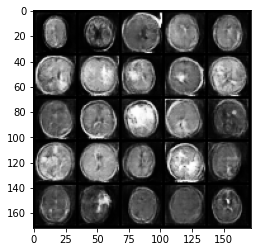

In [31]:
samples = generate_samples(gen, z_dim, device, n_samples=2900)
show_tensor_images(samples)

In [32]:
samples.shape

torch.Size([2900, 1, 32, 32])

### FID and IS score

In [34]:
# use CPU
from torchmetrics.image.fid import FrechetInceptionDistance

trainloader1 = DataLoader(train_data, batch_size=2900, shuffle=True, drop_last=True)
batch, label = next(iter(trainloader1))
print(f"Feature batch shape: {batch.shape}")
# print(f"Imgs batch shape: {imgs.shape}")


Feature batch shape: torch.Size([2900, 1, 32, 32])


In [45]:
samples = torch.cat((samples, samples, samples), dim=1)
samples.shape

torch.Size([2900, 3, 32, 32])

In [46]:
batch = torch.cat((batch, batch, batch), dim=1)
batch.shape

torch.Size([2900, 3, 32, 32])

In [49]:
samples *= 255

# Clamp values between 0 and 255
samples.clamp_(0, 255)

# Round to nearest integer
samples_uint8 = torch.round(samples).to(torch.uint8)


In [47]:
fid = FrechetInceptionDistance(normalize=True)
fid.update(batch, real=True)
fid.update(samples.cpu(), real=False)
print(f"FID: {float(fid.compute())}")
#FID: 149.07894897460938

FID: 149.07894897460938


In [53]:
from torchmetrics.image.inception import InceptionScore
inception = InceptionScore()
inception.update(samples_uint8.cpu())
inception.compute()

(tensor(2.3524), tensor(0.0655))